In [9]:
# !pip install fastai --upgrade

In [114]:
from fastai.vision.all import *
import os
import numpy as np
import random
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
delIndices = set(random.sample(range(len(os.listdir("train"))),5000))

for i, path in enumerate(os.listdir("train")):
  if i in delIndices:
    os.remove("train/"+path)

 # Simple CNN

In [44]:
# Check if images are broken then remove
fileNames = get_image_files("train")
fail = verify_images(fileNames)

# if fails remove those images
fail.map(Path.unlink)
 

(#0) []

## Data -> DataLoaders

In [50]:
def get_label(path):
  # train/cats.id.jpg
  return str(path).split(".")[0][-3:]

# DATA BLOCK
animals = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.3,seed=42),
    get_y = get_label,
    item_tfms = Resize(128)
)

# ref : ImageBlock, CategoryBlock are predefined blocks

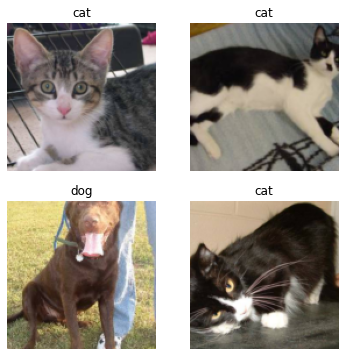

In [53]:
# DataLoader
dls = animals.dataloaders(Path("train"))
dls.valid.show_batch(max_n=4,nrows=2)

## Train Model

In [73]:
# Create same datablock but with few changes

# item_tfms -> for each image
# batch_tfms -> done for mini_batch while training using GPU
# aug_transforms only allowed on Training set not validation set
animals = animals.new(
    item_tfms = Resize(128, ResizeMethod.Squish),
    batch_tfms = aug_transforms(mult=2)
)

dls = animals.dataloaders(Path("train"))

In [55]:
learner = cnn_learner(dls, resnet18, metrics=error_rate)
learner.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,0.412933,0.084033,0.027778,00:22


epoch,train_loss,valid_loss,error_rate,time
0,0.102543,0.112523,0.030000,00:22
1,0.114226,0.122954,0.023333,00:22
2,0.094598,0.082639,0.024444,00:22
3,0.070814,0.071318,0.022222,00:22


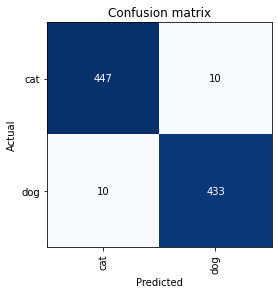

In [58]:
# Confusion Matrix
interpret = ClassificationInterpretation.from_learner(learner)
interpret.plot_confusion_matrix()

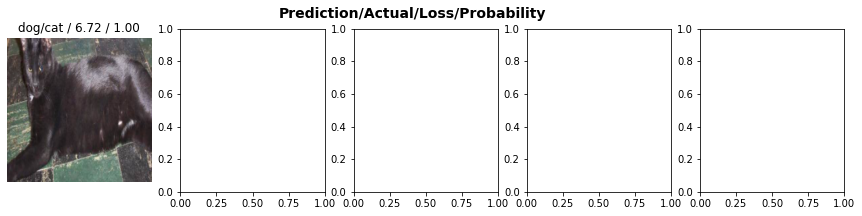

In [67]:
# Top losses
interpret.plot_top_losses(5,nrows=1)

## Image Dataset Cleaner

In [75]:
# based on your trained model suggestions are made about data (Based on losses)
# Options : Classify properly or delete

from fastai.vision.widgets import ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learner)
cleaner

In [ ]:
# Get images marked for removal
for idx in clearner.delete():
  cleaner.fns[idx].unlink()
  
# Get images marked for change
for idx, new_category_picked in cleaner.change():
  filePath = str(cleaner.fns[idx])
  # use python libs to rename the file

## Saving Model

In [68]:
# Saved as export.pkl
learner.export()

In [70]:
# Loading Model
loaded_lr = load_learner("export.pkl")
loaded_lr.predict("train/"+os.listdir("train")[0])

('cat', tensor(0), tensor([1.0000e+00, 1.7756e-07]))

In [71]:
loaded_lr.dls.vocab

['cat', 'dog']

# MNSIT

In [87]:
mnist_path = untar_data(URLs.MNIST_SAMPLE)
print(mnist_path)

/root/.fastai/data/mnist_sample


[Path('/root/.fastai/data/mnist_sample/valid'), Path('/root/.fastai/data/mnist_sample/train'), Path('/root/.fastai/data/mnist_sample/labels.csv')]


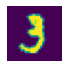

In [120]:
print(mnist_path.ls())
threes = (mnist_path/'train'/'3').ls().sorted()
sevens = (mnist_path/'train'/'7').ls().sorted()

three_tensors = [tensor(Image.open(x)) for x in threes]
seven_tensors = [tensor(Image.open(x)) for x in sevens]

show_image(three_tensors[0])

In [121]:
# Read image as tensor
temp = three_tensors[1]
df = pd.DataFrame(temp[4:40,4:40])
df.style.background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0,0,0,0,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0,0,0,0,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0,0,0,0,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0,0,0,0,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0,0,0,0,0,0,0


array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)